In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

2025-04-26 17:03:44.719230: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-26 17:03:44.720234: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-26 17:03:44.724351: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-26 17:03:44.736305: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745701424.755894  190543 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745701424.76

In [2]:
#shape of VAE is 38, 100, 100, 2, 100, 100 38

In [3]:
plt.rcParams['axes.titlesize'] = 13
plt.rcParams['axes.labelsize'] = 13
plt.rcParams['xtick.labelsize'] = 11
plt.rcParams['ytick.labelsize'] = 11
plt.rcParams['figure.figsize'] = (12,8)
plt.rcParams['legend.fontsize'] = 13

Data preprocessing (same step for all methods):

In [4]:
data = pd.read_csv('../tsne_umap_tutorials/data/APOGEEDR17_GAIAEDR3_noflagfilter.csv', delimiter=',')

# data = pd.read_csv('APOGEEDR17_GAIAEDR3_noflagfilter.csv', delimiter=',')

In [5]:
# Spatial:
ra = data["RA"]   #APOGEE
dec = data["DEC"]   #APOGEE

# Identification:
apogee_ID = data["# APOGEE_ID_"]   #APOGEE
gaia_ID = data["GAIAEDR3_SOURCE_ID"]  # Gaia

# Kinematic:
parallax = data["GAIAEDR3_PARALLAX"]  # Gaia
pmra = data["GAIAEDR3_PMRA"]  # Gaia
pmra_err = data["GAIAEDR3_PMRA_ERROR"]  # Gaia
pmdec = data["GAIAEDR3_PMDEC"]  # Gaia
pmdec_err = data["GAIAEDR3_PMDEC_ERROR"]  # Gaia
RV = data["VHELIO_AVG"]   #APOGEE
RV_err = data["VERR"]   #APOGEE
#dist = data["dist"]   #APOGEE no dist in this dataset?
#dist_err = data["dist_err"]   #APOGEE
jr = data["jr"]   #APOGEE
jr_err = data["jr_err"]   #APOGEE
jz = data["jz"]   #APOGEE
jz_err = data["jz_err"]   #APOGEE
#jphi = data["jphi"]   #APOGEE no jphi in this dataset?
#jphi_err = data["jphi_err"]    #APOGEE

# # Spectral (useful for filtering):
TEFF_ERR = data["TEFF_ERR"]   #APOGEE
TEFF = data["TEFF"]   #APOGEE
LOGG_ERR = data["LOGG_ERR"]   #APOGEE
LOGG = data["LOGG"]   #APOGEE
SNR = data["SNR"]   #APOGEE
ASPCAPFLAG = data["ASPCAPFLAG"]
STARFLAG = data["STARFLAG"]

# # Chemical abundances from astroNN:
FE_H = data['FE_H'] 
C_FE = data['C_FE']
CI_FE = data['CI_FE']
N_FE = data['N_FE']
O_FE = data['O_FE']
MG_FE = data['MG_FE']
AL_FE = data['AL_FE']
SI_FE = data['SI_FE']
P_FE = data['P_FE']
S_FE = data['S_FE']
K_FE = data['K_FE']
CA_FE = data['CA_FE']
TI_FE = data['TI_FE']
TIII_FE = data['TIII_FE']
V_FE = data['V_FE']
CR_FE = data['CR_FE']
MN_FE = data['MN_FE']
CO_FE = data['CO_FE']
NI_FE = data['NI_FE']

# # Chemical abundance errors from astroNN:
FE_H_err = data["FE_H_ERR"] 
C_FE_err = data['C_FE_ERR']
CI_FE_err = data['CI_FE_ERR']
N_FE_err = data['N_FE_ERR']
O_FE_err = data['O_FE_ERR']
MG_FE_err = data['MG_FE_ERR']
AL_FE_err = data['AL_FE_ERR']
SI_FE_err = data['SI_FE_ERR']
P_FE_err = data['P_FE_ERR']
S_FE_err = data['S_FE_ERR']
K_FE_err = data['K_FE_ERR']
CA_FE_err = data['CA_FE_ERR']
TI_FE_err = data['TI_FE_ERR']
TIII_FE_err = data['TIII_FE_ERR']
V_FE_err = data['V_FE_ERR']
CR_FE_err = data['CR_FE_ERR']
MN_FE_err = data['MN_FE_ERR']
CO_FE_err = data['CO_FE_ERR']
NI_FE_err = data['NI_FE_ERR']

# # Number of stars in the initial sample of APOGEE DR16: 
print("There are {} stars in our initial sample".format(len(ra)))

cols = [ra, dec, apogee_ID, gaia_ID, parallax, pmra, pmra_err, pmdec, pmdec_err, RV, RV_err, #dist, dist_err,
         jr, jr_err,# jphi, jphi_err,
        jz, jz_err, TEFF, TEFF_ERR, LOGG, LOGG_ERR, SNR, ASPCAPFLAG, STARFLAG, FE_H, FE_H_err, C_FE, 
         C_FE_err, CI_FE, CI_FE_err, N_FE, N_FE_err, O_FE, O_FE_err, MG_FE, MG_FE_err, AL_FE, AL_FE_err, SI_FE,
         SI_FE_err, P_FE, P_FE_err, S_FE, S_FE_err, K_FE, K_FE_err, CA_FE, CA_FE_err, TI_FE, TI_FE_err, TIII_FE,
         TIII_FE_err, V_FE, V_FE_err, CR_FE, CR_FE_err, MN_FE, MN_FE_err, CO_FE, CO_FE_err, NI_FE, NI_FE_err]

There are 370060 stars in our initial sample


In [6]:
aspcapflags_filter = np.array(cols[20])==0
starflags_filter = np.array(cols[21])==0

filters = aspcapflags_filter*starflags_filter


filtered_data = []
for c in cols:
    a = np.array(c)[filters]
    filtered_data.append(a)
    
print("There are {} stars in our filtered sample".format(len(filtered_data[0])))

There are 144767 stars in our filtered sample


In [7]:
FE_H_filtered, C_FE_filtered, CI_FE_filtered = filtered_data[22], filtered_data[24], filtered_data[26]
N_FE_filtered, O_FE_filtered, MG_FE_filtered = filtered_data[28], filtered_data[30], filtered_data[32]
AL_FE_filtered, SI_FE_filtered, P_FE_filtered = filtered_data[34], filtered_data[36], filtered_data[38]
S_FE_filtered, K_FE_filtered, CA_FE_filtered = filtered_data[40], filtered_data[42], filtered_data[44]
TI_FE_filtered, TIII_FE_filtered, V_FE_filtered = filtered_data[46], filtered_data[48], filtered_data[50]
CR_FE_filtered, MN_FE_filtered, CO_FE_filtered, NI_FE_filtered = filtered_data[52], filtered_data[54], filtered_data[56], filtered_data[58]
RV_filtered  = filtered_data[9]

In [8]:
FE_H_err, C_FE_err, CI_FE_err = filtered_data[23], filtered_data[25], filtered_data[27]
N_FE_err, O_FE_err, MG_FE_err = filtered_data[29], filtered_data[31], filtered_data[33]
AL_FE_err, SI_FE_err, P_FE_err = filtered_data[35], filtered_data[37], filtered_data[39]
S_FE_err, K_FE_err, CA_FE_err = filtered_data[41], filtered_data[43], filtered_data[45]
TI_FE_err, TIII_FE_err, V_FE_err = filtered_data[47], filtered_data[49], filtered_data[51]
CR_FE_err, MN_FE_err, CO_FE_err, NI_FE_err = filtered_data[53], filtered_data[55], filtered_data[57], filtered_data[59]
RV_err  = filtered_data[10]

In [9]:
train_size = round(0.8 * len(filtered_data[0]))
test_size = round(0.1 * len(filtered_data[0]))
validation_size = round(0.1 * len(filtered_data[0]))

training_labels_raw = np.transpose(np.array([FE_H_filtered[:train_size], C_FE_filtered[:train_size], CI_FE_filtered[:train_size], 
                                        N_FE_filtered[:train_size], O_FE_filtered[:train_size], MG_FE_filtered[:train_size],
                                        AL_FE_filtered[:train_size], SI_FE_filtered[:train_size], P_FE_filtered[:train_size],
                                        S_FE_filtered[:train_size], K_FE_filtered[:train_size], CA_FE_filtered[:train_size],
                                        TI_FE_filtered[:train_size], TIII_FE_filtered[:train_size], V_FE_filtered[:train_size], 
                                        CR_FE_filtered[:train_size], MN_FE_filtered[:train_size], CO_FE_filtered[:train_size], NI_FE_filtered[:train_size]]))

error_training_labels_raw = np.transpose(np.array([FE_H_err[:train_size], C_FE_err[:train_size], CI_FE_err[:train_size], 
                                        N_FE_err[:train_size], O_FE_err[:train_size], MG_FE_err[:train_size],
                                        AL_FE_err[:train_size], SI_FE_err[:train_size], P_FE_err[:train_size],
                                        S_FE_err[:train_size], K_FE_err[:train_size], CA_FE_err[:train_size],
                                        TI_FE_err[:train_size], TIII_FE_err[:train_size], V_FE_err[:train_size], 
                                        CR_FE_err[:train_size], MN_FE_err[:train_size], CO_FE_err[:train_size], NI_FE_err[:train_size]]))


test_labels_raw = np.transpose(np.array([FE_H_filtered[train_size: train_size + test_size], C_FE_filtered[train_size: train_size + test_size], 
                                     CI_FE_filtered[train_size: train_size + test_size], N_FE_filtered[train_size: train_size + test_size],
                                     O_FE_filtered[train_size: train_size + test_size], MG_FE_filtered[train_size: train_size + test_size],
                                        AL_FE_filtered[train_size: train_size + test_size], SI_FE_filtered[train_size: train_size + test_size], 
                                     P_FE_filtered[train_size: train_size + test_size], S_FE_filtered[train_size: train_size + test_size], 
                                     K_FE_filtered[train_size: train_size + test_size], CA_FE_filtered[train_size: train_size + test_size],
                                        TI_FE_filtered[train_size: train_size + test_size], TIII_FE_filtered[train_size: train_size + test_size], 
                                     V_FE_filtered[train_size: train_size + test_size], CR_FE_filtered[train_size: train_size + test_size], 
                                     MN_FE_filtered[train_size: train_size + test_size], CO_FE_filtered[train_size: train_size + test_size], 
                                     NI_FE_filtered[train_size: train_size + test_size]]))
                                     
                                     
error_test_labels_raw = np.transpose(np.array([FE_H_err[train_size: train_size + test_size], C_FE_err[train_size: train_size + test_size], CI_FE_err[train_size: train_size + test_size], 
                                        N_FE_err[train_size: train_size + test_size], O_FE_err[train_size: train_size + test_size], MG_FE_err[train_size: train_size + test_size],
                                        AL_FE_err[train_size: train_size + test_size], SI_FE_err[train_size: train_size + test_size], P_FE_err[train_size: train_size + test_size],
                                        S_FE_err[train_size: train_size + test_size], K_FE_err[train_size: train_size + test_size], CA_FE_err[train_size: train_size + test_size],
                                        TI_FE_err[train_size: train_size + test_size], TIII_FE_err[train_size: train_size + test_size], V_FE_err[train_size: train_size + test_size], 
                                        CR_FE_err[train_size: train_size + test_size], MN_FE_err[train_size: train_size + test_size], CO_FE_err[train_size: train_size + test_size], NI_FE_err[train_size: train_size + test_size]]))


validation_labels_raw = np.transpose(np.array([FE_H_filtered[train_size + test_size: train_size + test_size + validation_size], C_FE_filtered[train_size + test_size: train_size + test_size + validation_size], 
                                     CI_FE_filtered[train_size + test_size: train_size + test_size + validation_size], N_FE_filtered[train_size + test_size: train_size + test_size + validation_size],
                                     O_FE_filtered[train_size + test_size: train_size + test_size + validation_size], MG_FE_filtered[train_size + test_size: train_size + test_size + validation_size],
                                        AL_FE_filtered[train_size + test_size: train_size + test_size + validation_size], SI_FE_filtered[train_size + test_size: train_size + test_size + validation_size], 
                                     P_FE_filtered[train_size + test_size: train_size + test_size + validation_size], S_FE_filtered[train_size + test_size: train_size + test_size + validation_size], 
                                     K_FE_filtered[train_size + test_size: train_size + test_size + validation_size], CA_FE_filtered[train_size + test_size: train_size + test_size + validation_size],
                                        TI_FE_filtered[train_size + test_size: train_size + test_size + validation_size], TIII_FE_filtered[train_size + test_size: train_size + test_size + validation_size], 
                                     V_FE_filtered[train_size + test_size: train_size + test_size + validation_size], CR_FE_filtered[train_size + test_size: train_size + test_size + validation_size], 
                                     MN_FE_filtered[train_size + test_size: train_size + test_size + validation_size], CO_FE_filtered[train_size + test_size: train_size + test_size + validation_size], 
                                     NI_FE_filtered[train_size + test_size: train_size + test_size + validation_size]]))
                                     
                                     
error_validation_labels_raw = np.transpose(np.array([FE_H_err[train_size + test_size: train_size + test_size + validation_size], C_FE_err[train_size + test_size: train_size + test_size + validation_size], CI_FE_err[train_size + test_size: train_size + test_size + validation_size], 
                                        N_FE_err[train_size + test_size: train_size + test_size + validation_size], O_FE_err[train_size + test_size: train_size + test_size + validation_size], MG_FE_err[train_size + test_size: train_size + test_size + validation_size],
                                        AL_FE_err[train_size + test_size: train_size + test_size + validation_size], SI_FE_err[train_size + test_size: train_size + test_size + validation_size], P_FE_err[train_size + test_size: train_size + test_size + validation_size],
                                        S_FE_err[train_size + test_size: train_size + test_size + validation_size], K_FE_err[train_size + test_size: train_size + test_size + validation_size], CA_FE_err[train_size + test_size: train_size + test_size + validation_size],
                                        TI_FE_err[train_size + test_size: train_size + test_size + validation_size], TIII_FE_err[train_size + test_size: train_size + test_size + validation_size], V_FE_err[train_size + test_size: train_size + test_size + validation_size], 
                                        CR_FE_err[train_size + test_size: train_size + test_size + validation_size], MN_FE_err[train_size + test_size: train_size + test_size + validation_size], CO_FE_err[train_size + test_size: train_size + test_size + validation_size], NI_FE_err[train_size + test_size: train_size + test_size + validation_size]]))


In [10]:
full_training_labels_raw = np.c_[training_labels_raw, error_training_labels_raw]
full_test_labels_raw = np.c_[test_labels_raw, error_test_labels_raw]
full_validation_labels_raw = np.c_[validation_labels_raw, error_validation_labels_raw]

In [11]:
full_training_labels_raw.shape, full_test_labels_raw.shape, full_validation_labels_raw.shape

((115814, 38), (14477, 38), (14476, 38))

In [12]:
np.min(full_training_labels_raw.T, axis=1), np.max(full_training_labels_raw.T, axis=1)

(array([-1.951497  , -2.1234312 , -2.119044  , -0.18978369, -0.7124527 ,
        -0.15558027, -0.47890055, -0.15707995, -0.97891414, -0.6047195 ,
        -2.2741165 , -0.40278423, -1.2907453 , -0.6157368 , -1.1658391 ,
        -1.391077  , -0.64225805, -3.6896837 , -0.2965148 ,  0.01358107,
         0.01762647,  0.02378747,  0.01708818,  0.01984493,  0.02071843,
         0.02232191,  0.01871411,  0.05818468,  0.01897749,  0.03516773,
         0.02518716,  0.02486172,  0.02255343,  0.0375476 ,  0.02254345,
         0.02762588,  0.01909786,  0.02221127]),
 array([5.7460123e-01, 8.3517190e-01, 5.6674075e-01, 3.6616602e+00,
        5.5585840e-01, 5.1025960e-01, 4.8934165e-01, 4.5210746e-01,
        7.5247210e+00, 9.0582700e-01, 1.0242985e+00, 2.7282690e-01,
        5.9501344e-01, 8.7636330e-01, 8.6697330e-01, 3.3210137e-01,
        3.5304812e-01, 5.6587050e-01, 2.1270613e-01, 4.5790780e-01,
        1.2761971e+00, 1.6784387e+00, 1.8850280e+01, 5.6260234e-01,
        5.5715760e-01, 6.7058295

In [13]:
err_threshold = 3 # remove errors that are larger than this...
err_mask_train = np.all(np.abs(full_training_labels_raw) < err_threshold, axis=1)
err_mask_test = np.all(np.abs(full_test_labels_raw) < err_threshold, axis=1)
err_mask_validation = np.all(np.abs(full_validation_labels_raw) < err_threshold, axis=1)

Remove unreasonably huge errors bars or unphysical abundance estimates:

In [14]:
full_training_labels = full_training_labels_raw[err_mask_train]
full_test_labels = full_test_labels_raw[err_mask_test]
full_validation_labels = full_validation_labels_raw[err_mask_validation]

In [15]:
full_training_labels.shape, full_test_labels.shape, full_validation_labels.shape

((114885, 38), (14374, 38), (14326, 38))

In [16]:
np.min(full_training_labels.T, axis=1), np.max(full_training_labels.T, axis=1)

(array([-1.8320073 , -1.2602895 , -2.119044  , -0.18978369, -0.7124527 ,
        -0.1388877 , -0.47890055, -0.13207644, -0.97891414, -0.5242982 ,
        -0.7713039 , -0.40278423, -1.2907453 , -0.6157368 , -1.1658391 ,
        -1.0536897 , -0.64225805, -1.1330373 , -0.2965148 ,  0.01358107,
         0.01762647,  0.02378747,  0.01708818,  0.01984493,  0.02071843,
         0.02232191,  0.01871411,  0.05818468,  0.01897749,  0.03516773,
         0.02518716,  0.02486172,  0.02255343,  0.0375476 ,  0.02254345,
         0.02762588,  0.01909786,  0.02221127]),
 array([0.57460123, 0.81556314, 0.56674075, 1.5901425 , 0.5558584 ,
        0.5102596 , 0.48934165, 0.45210746, 1.0318542 , 0.905827  ,
        1.0242985 , 0.262527  , 0.59501344, 0.8763633 , 0.8669733 ,
        0.27449507, 0.35304812, 0.5658705 , 0.21270613, 0.35667247,
        0.48992783, 1.637775  , 1.0633858 , 0.46304193, 0.43964195,
        0.55135024, 0.46292186, 2.998515  , 0.55373484, 2.87389   ,
        1.0069572 , 0.7626475 , 

In [17]:
from sklearn.preprocessing import StandardScaler

Manual scaler to standardize (equivalent to StandardScaler):

In [18]:
# standardized_pca_array = []
# standardization_means = np.zeros(len(np.array(x_df_transpose)))
# standardization_sigmas = np.zeros(len(np.array(x_df_transpose)))

# for i, param in enumerate(np.array(x_df_transpose)):
#     mean, sigma = np.mean(param), np.std(param)
#     norm = (param - mean)/sigma
#     standardized_pca_array.append(norm)
#     standardization_means[i] = mean
#     standardization_sigmas[i] = sigma

StandardScaler to standardize (same method for t-SNE/UMAP):

In [19]:
# split abundances and errors into separate datasets
training_labels_abundances = full_training_labels[:, :19]
training_labels_errors = full_training_labels[:, 19:]

test_labels_abundances = full_test_labels[:, :19]
test_labels_errors = full_test_labels[:, 19:]

validation_labels_abundances = full_validation_labels[:, :19]
validation_labels_errors = full_validation_labels[:, 19:]

standardized_abundance_training_arr = StandardScaler().fit_transform(training_labels_abundances)
standardized_error_training_arr = StandardScaler().fit_transform(training_labels_errors)
standardized_full_training_arr = StandardScaler().fit_transform(full_training_labels)

standardized_abundance_test_arr = StandardScaler().fit_transform(test_labels_abundances)
standardized_error_test_arr = StandardScaler().fit_transform(test_labels_errors)
standardized_full_test_arr = StandardScaler().fit_transform(full_test_labels)

standardized_abundance_validation_arr = StandardScaler().fit_transform(validation_labels_abundances)
standardized_error_validation_arr = StandardScaler().fit_transform(validation_labels_errors)
standardized_full_validation_arr = StandardScaler().fit_transform(full_validation_labels)

VAE stuff:

Classes used in VAEs:

In [20]:
class Sampling(layers.Layer):
    """Uses (mean, log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        mean, log_var = inputs
        batch = tf.shape(mean)[0]
        dim = tf.shape(mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return mean + tf.exp(0.5 * log_var) * epsilon

class mu_var(tf.keras.Layer):
    def call(self, x_mu, x_log_var):
        return tf.concat([x_mu, x_log_var], 1)

## Load all methods:

PCA:

In [21]:
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA

n_params = len(training_labels_abundances.T)
# perform PCA
pca = PCA(n_components = 2)
# fit the pca using the training array
fit_pca = pca.fit(standardized_abundance_training_arr)

# transform the training array
train_pca = fit_pca.transform(standardized_abundance_training_arr)
reconstructed_abundance_training_arr = fit_pca.inverse_transform(train_pca)
# transform the test array
test_pca = fit_pca.transform(standardized_abundance_test_arr)
reconstructed_abundance_test_arr = fit_pca.inverse_transform(test_pca)
# compute MSE
pca_training_mse = np.mean((standardized_abundance_training_arr - reconstructed_abundance_training_arr) ** 2) * 1000
pca_test_mse = np.mean((standardized_abundance_test_arr - reconstructed_abundance_test_arr) ** 2) * 1000

Naive and Modified VAE:

In [22]:
keras.utils.get_custom_objects().update({
    "Sampling": Sampling,
    "mu_var": mu_var
})

encoder_naive = tf.keras.models.load_model('encoder_naive_vae.keras')
decoder_naive = tf.keras.models.load_model('decoder_naive_vae.keras')
encoder_modified = tf.keras.models.load_model('encoder_modified_vae.keras')
decoder_modified = tf.keras.models.load_model('decoder_modified_vae.keras')

with open('naive_vae_history.pkl', 'rb') as f:
    naive_history = pickle.load(f)

with open('modified_vae_history.pkl', 'rb') as f:
    modified_history = pickle.load(f)

2025-04-26 17:03:52.717521: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


### Plot all:

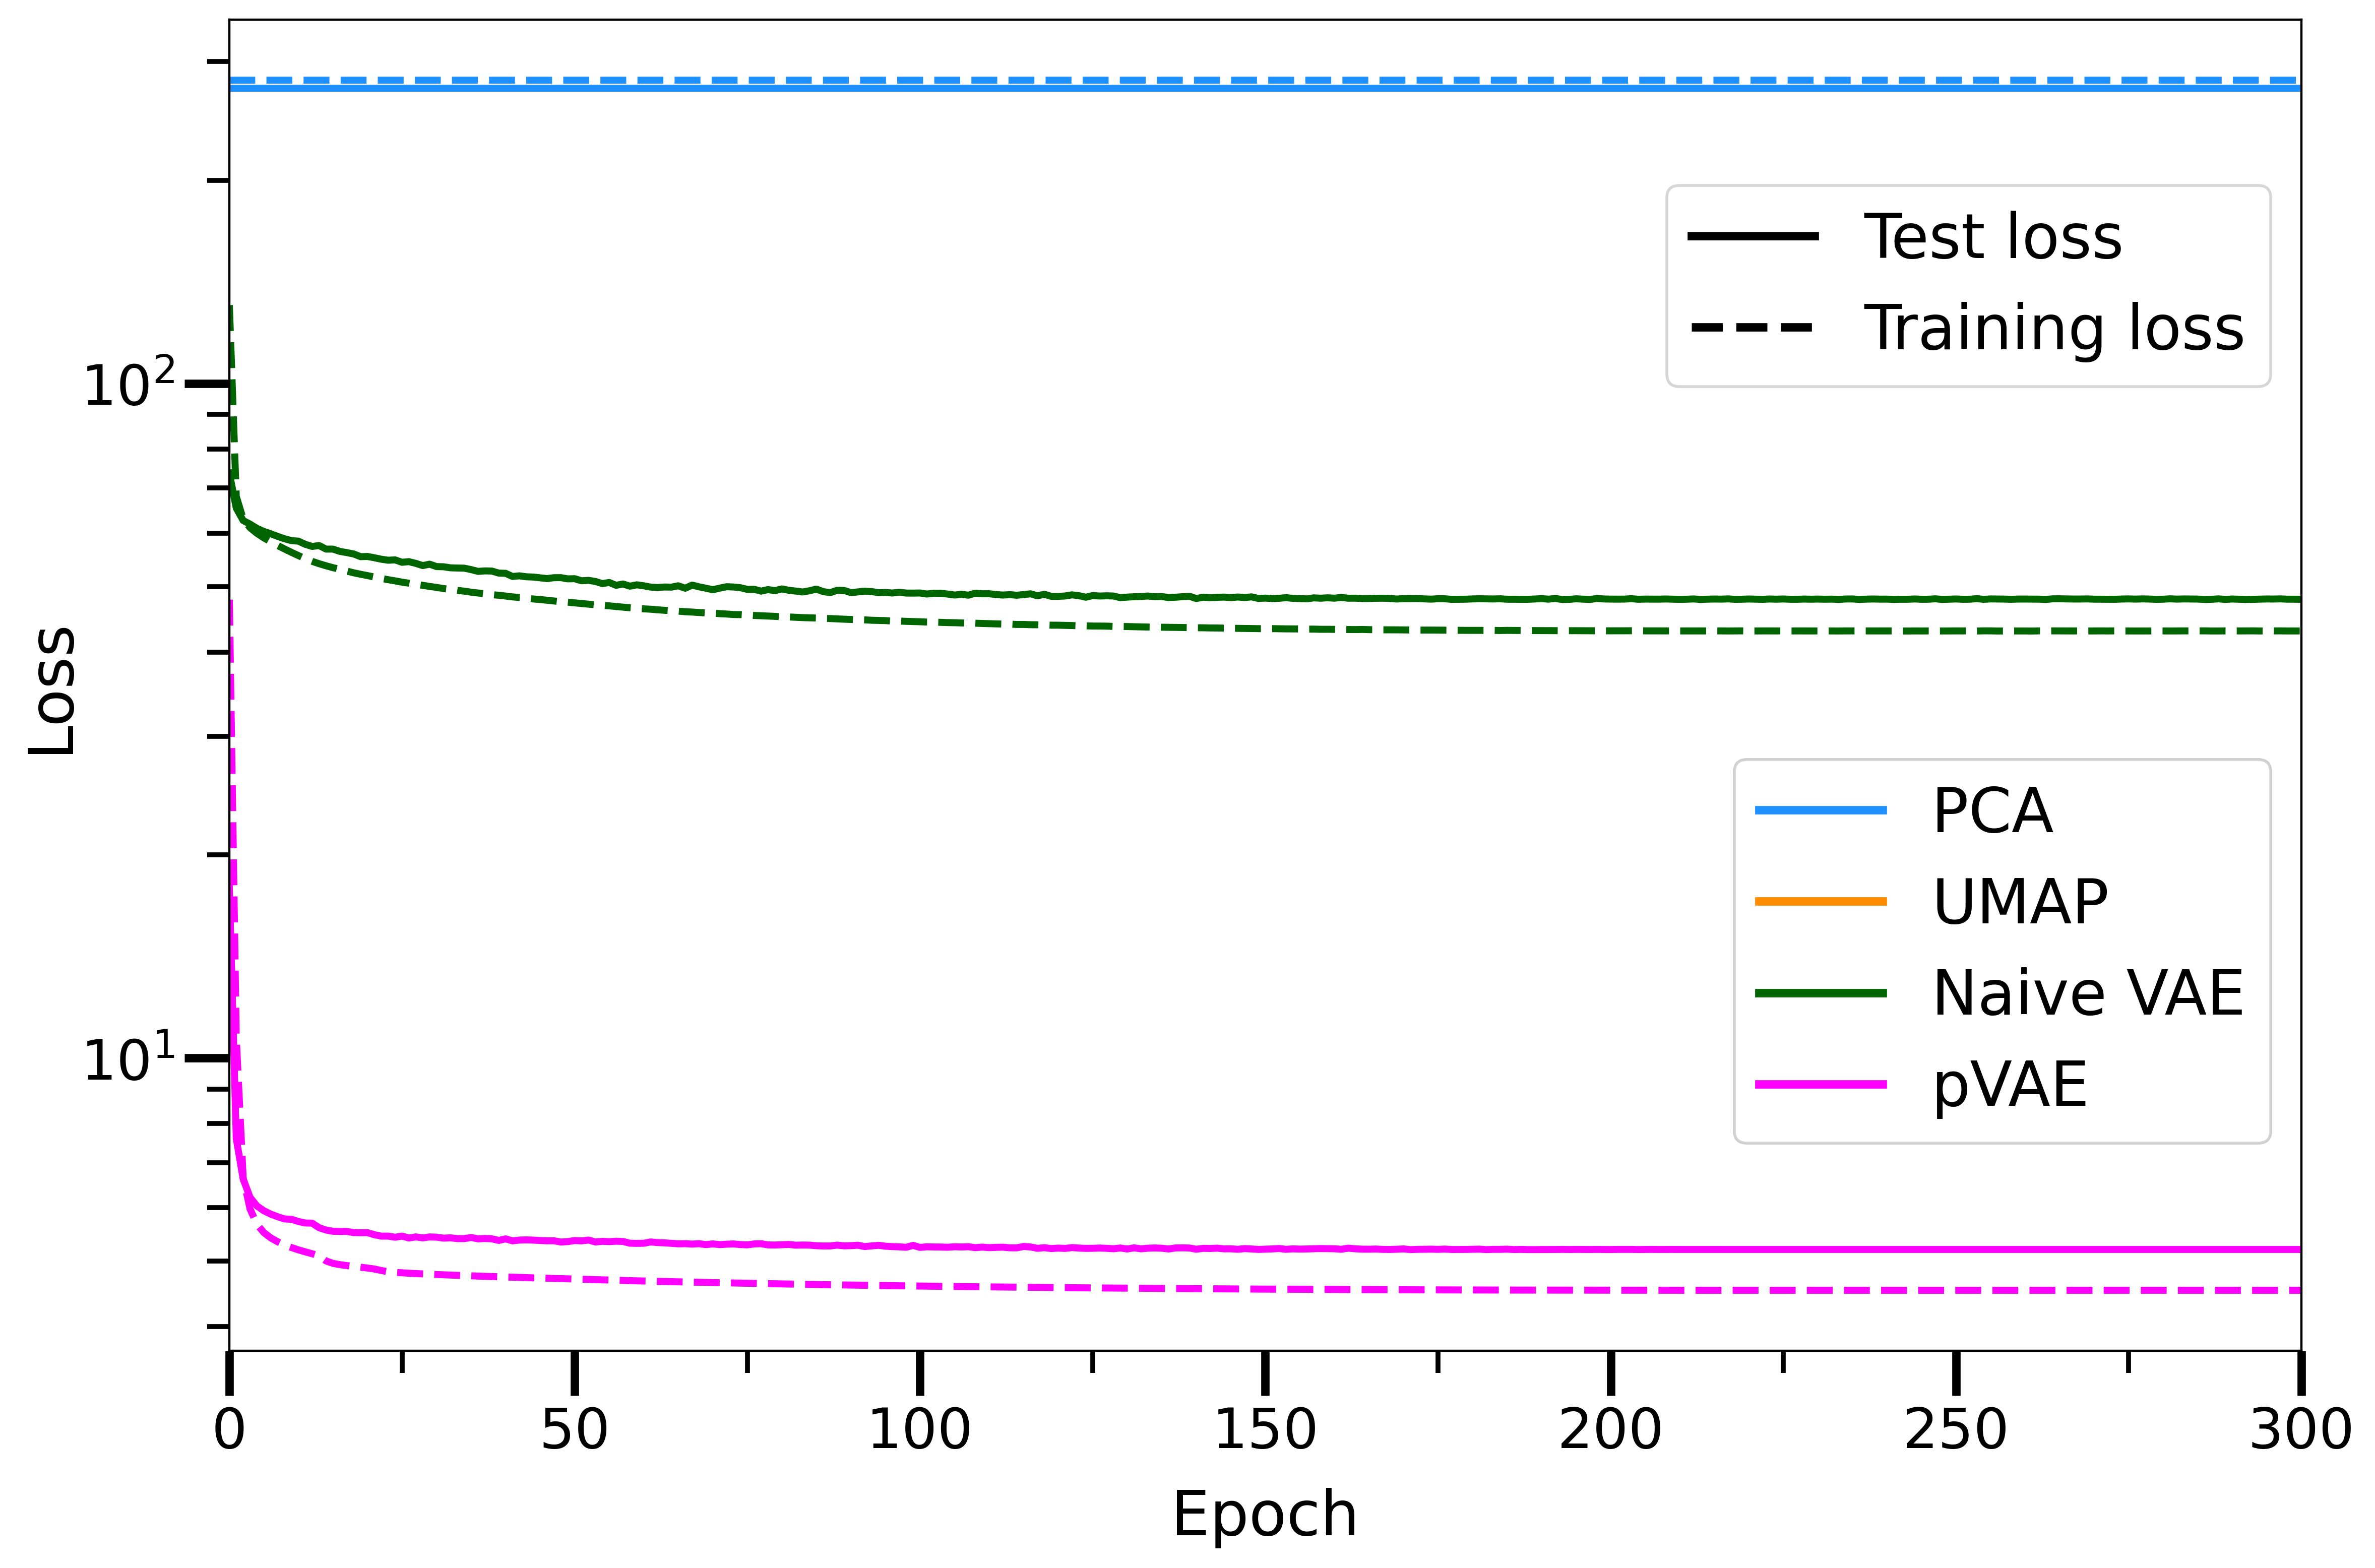

In [40]:
from matplotlib.ticker import MultipleLocator

fig, ax = plt.subplots(1, 1, figsize = (12, 8), dpi=400)
# plot PCA
plt.axhline(pca_training_mse, linewidth=2.5, color='dodgerblue', linestyle='dashed')
plt.axhline(pca_test_mse, linewidth=2.5, color='dodgerblue', linestyle='solid')
# naive VAE
plt.plot(naive_history['total loss'], linewidth=2.5, color='darkgreen', linestyle='dashed')
plt.plot(naive_history['val_total loss'], linewidth=2.5, color='darkgreen', linestyle='solid')
# modified VAE
plt.plot(modified_history['total loss'], linewidth=2.5, color='fuchsia', linestyle='dashed')
plt.plot(modified_history['val_total loss'], linewidth=2.5, color='fuchsia', linestyle='solid')
# dummy lines
# test/train
dl1, = plt.plot([], [], c='black', linestyle='solid', linewidth=3.)
dl2, = plt.plot([], [], c='black', linestyle='dashed', linewidth=3.)
# PCA, UMAP, naive VAE, pVAE
dl3, = plt.plot([], [], c='dodgerblue', linestyle='solid', linewidth=3.)
dl4, = plt.plot([], [], c='darkorange', linestyle='solid', linewidth=3.)
dl5, = plt.plot([], [], c='darkgreen', linestyle='solid', linewidth=3.)
dl6, = plt.plot([], [], c='fuchsia', linestyle='solid', linewidth=3.)
# scale
plt.yscale('log')
# plt.xscale('log')
# tick params
plt.tick_params('both', length=16, width=3., which='major', labelsize=20)
plt.tick_params('both', length=8, width=1.75, which='minor', labelsize=20)
ax.xaxis.set_minor_locator(MultipleLocator(25.))
# limit, label
plt.xlim(0, 300)
plt.xlabel('Epoch', fontsize=22, labelpad=10)
plt.ylabel('Loss', fontsize=22, labelpad=0)
# legend
l1 = plt.legend([dl1, dl2], ['Test loss', 'Training loss'], bbox_to_anchor=(1., 0.8), loc='right', fontsize=22)
l2 = plt.legend([dl3, dl4, dl5, dl6], [r'PCA', r'UMAP', r'Naive VAE', r'pVAE'], bbox_to_anchor=(1., 0.3), loc='right', fontsize=22)
ax.add_artist(l2)
ax.add_artist(l1)
# tight layout, save
plt.tight_layout()
plt.savefig('./paper_figures/loss_vs_epoch.png')

Train "naive" VAE:

In [24]:
# # training_labels, error_training_labels = full_training_labels[:, :19], full_training_labels[:, 19:]
# # test_labels, error_test_labels = full_test_labels[:, :19], full_test_labels[:, 19:]
# # validation_labels, error_validation_labels = full_validation_labels[:, :19], full_validation_labels[:, 19:]

# ### CHECKPOINTING:

# class EpochCheckpoint(tf.keras.callbacks.Callback):
#     def __init__(self, save_every=50, save_path='naive_vae_checkpoints/ckpt-epoch-{epoch:02d}.weights.h5'):
#         super().__init__()
#         self.save_every = save_every
#         self.save_path = save_path

#     def on_epoch_end(self, epoch, logs=None):
#         if (epoch + 1) % self.save_every == 0:
#             filepath = self.save_path.format(epoch=epoch + 1)
#             self.model.save_weights(filepath)
#             print(f"Checkpoint saved at epoch {epoch + 1}")

# # optimizer
# optimizer = keras.optimizers.Adam(learning_rate=lr_schedule)
# # VAE
# vae = VAE(encoder, decoder)
# vae.compile(optimizer=optimizer, metrics=['mse', 'accuracy'])
# # FIT
# # vae.fit(training_labels, epochs=5000, batch_size=256, callbacks=lr_callback)
# history = vae.fit(standardized_abundance_training_arr, 
#                   epochs=5000, batch_size=256, 
#                   validation_data=standardized_abundance_test_arr, 
#                   callbacks=[EpochCheckpoint(save_every=50)])

save:

In [25]:
# # save the model?
# encoder.save('encoder_naive_vae.keras', overwrite=True)#, save_format='tf')
# decoder.save('decoder_naive_vae.keras', overwrite=True)#, save_format='tf')
# # save the history as well
# # Save history object
# with open('naive_vae_history.pkl', 'wb') as f:
#     pickle.dump(history.history, f)

Load encoder, decoder and history:

In [26]:
keras.utils.get_custom_objects().update({
    "Sampling": Sampling,
})

encoder = tf.keras.models.load_model('encoder_naive_vae.keras')
decoder = tf.keras.models.load_model('decoder_naive_vae.keras')

with open('naive_vae_history.pkl', 'rb') as f:
    history = pickle.load(f)

len(history['total loss'])

5000

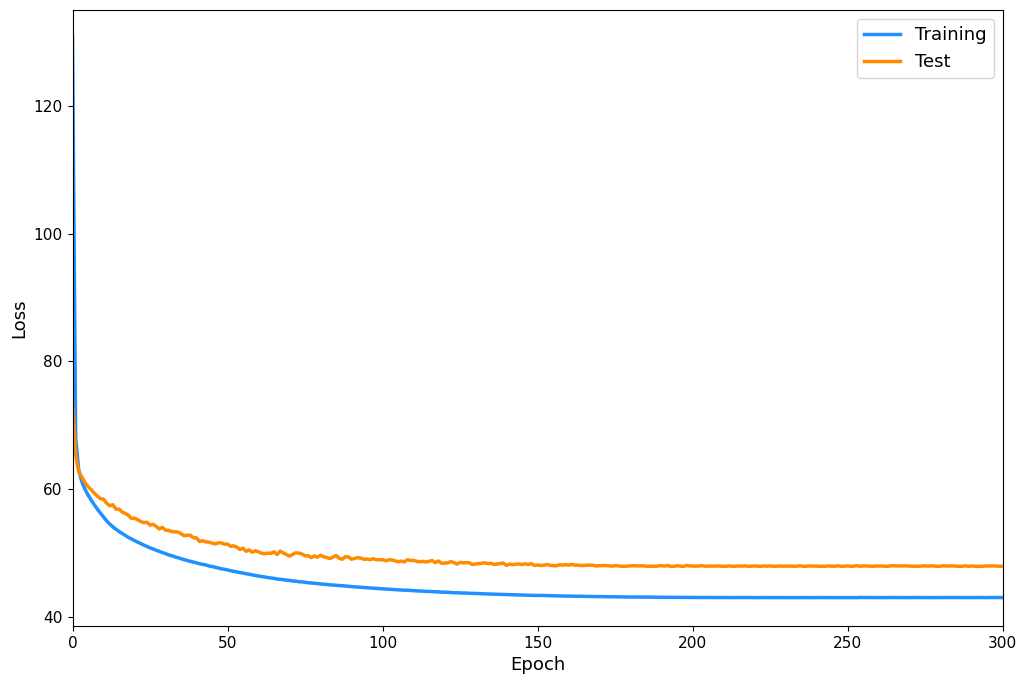

In [27]:
# plt.ylim(4.5, 7.)
# plt.plot(history['reconstruction_loss'])
# plt.plot(history['kl loss'])
plt.plot(history['total loss'], linewidth=2.5, color='dodgerblue', label = 'Training')
plt.plot(history['val_total loss'], linewidth=2.5, color='darkorange', label = 'Test')
plt.xlim(0, 300)
plt.xlabel('Epoch'), plt.ylabel('Loss')
plt.legend()

In [28]:
testmean, testvar, testz = encoder(standardized_abundance_test_arr)
test_reconstruction = decoder(testz)
standardized_abundance_test_arr, test_reconstruction

(array([[ 0.26717617,  0.58071564,  0.77119327, ...,  0.07171473,
          0.17625654,  0.18141452],
        [ 1.30125899, -0.6162556 , -1.75398675, ...,  1.32887713,
          0.47415769,  0.63605213],
        [ 0.2016009 , -0.34355209, -0.19853193, ..., -0.18691169,
          0.12079571, -0.44497627],
        ...,
        [-0.76002689, -0.58530829, -0.48424128, ..., -0.14240413,
          0.42637037, -0.7731237 ],
        [-0.36292976,  0.29027586,  0.34492908, ...,  0.28826048,
          0.58893306, -0.40693741],
        [ 0.97252638, -2.01160426, -2.7254828 , ...,  0.1629832 ,
         -0.81646843, -1.6595545 ]]),
 <tf.Tensor: shape=(14374, 19), dtype=float32, numpy=
 array([[ 0.44269714,  0.49715337,  0.3289244 , ...,  0.10441586,
          0.28614846, -0.22763754],
        [ 1.537733  , -0.21923047, -0.62553304, ...,  1.8171893 ,
          0.5638401 ,  0.24272248],
        [-0.18481544, -0.48263672, -0.48226064, ...,  0.27977675,
          0.26028863, -0.46255684],
        ...,


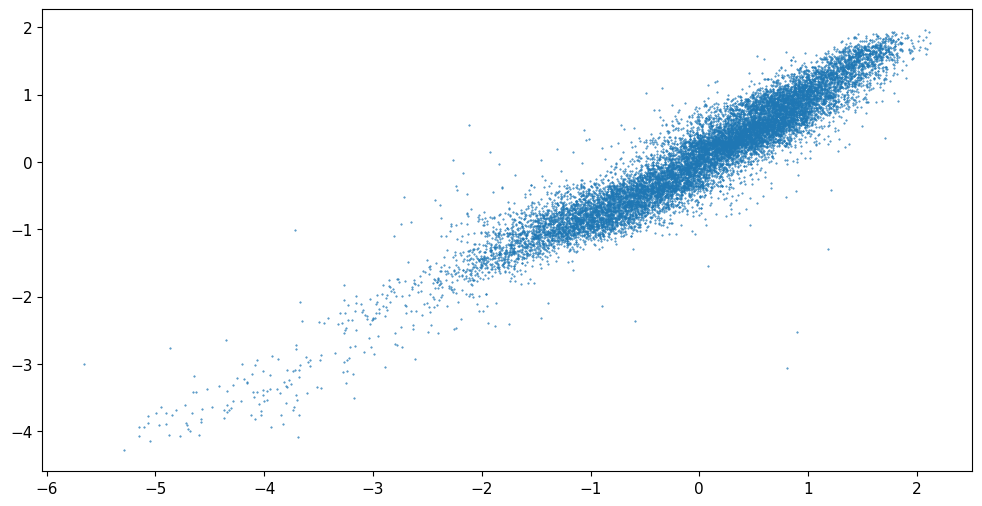

In [29]:
# mses = (test_reconstruction - standardized_abundance_test_arr)[:,0]

plt.figure(figsize = (12, 6))
plt.scatter(standardized_abundance_test_arr[:,0], test_reconstruction[:,0], s=0.2)
# plt.ylim(bottom=0., top=0.1)

(Text(0.5, 0, 'Original'), Text(0, 0.5, 'Reconstructed'))

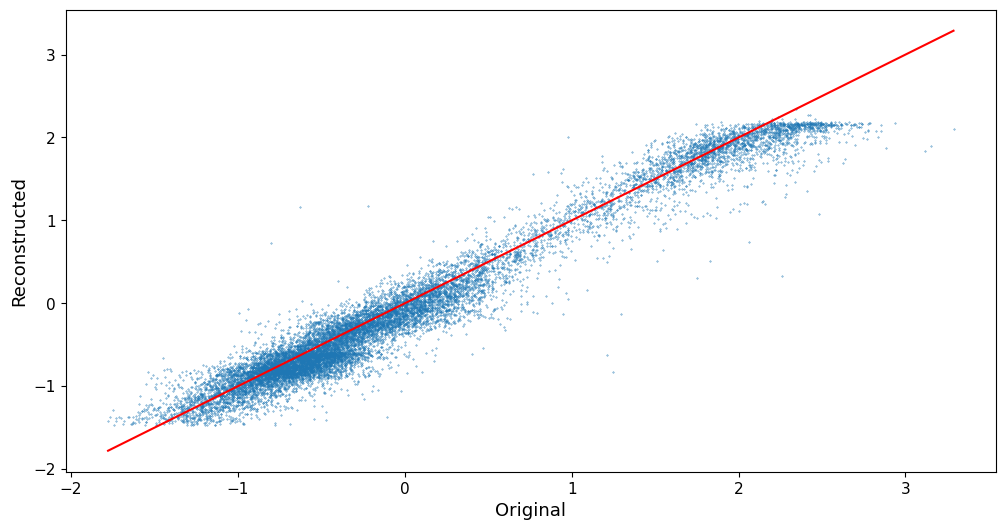

In [30]:
ind = 5  # 19 parameters, 0 to 18
samp_rate = 1

plt.figure(figsize = (12, 6))
plt.scatter(standardized_abundance_test_arr[:,ind][::samp_rate], test_reconstruction[:,ind][::samp_rate], s=0.1)#, xerr=np.exp(standardized_abundance_test_arr[:,ind+19][::samp_rate]/2), yerr=np.exp(test_reconstruction[:,ind+19][::samp_rate]/2), fmt='.', markersize=5, elinewidth=0.5)
# plt.plot(np.linspace(0., 0.3, int(1e4)), np.linspace(0., 0.3, int(1e4)), c='r')
plt.plot(np.linspace(np.min(standardized_abundance_test_arr[:,ind]), np.max(standardized_abundance_test_arr[:,ind]), int(1e5)), np.linspace(np.min(standardized_abundance_test_arr[:,ind]), np.max(standardized_abundance_test_arr[:,ind]), int(1e5)), c='r')
plt.xlabel('Original'), plt.ylabel('Reconstructed')
# plt.xlim(-0.5, 0.4)
# plt.ylim(-0.5, 0.4)

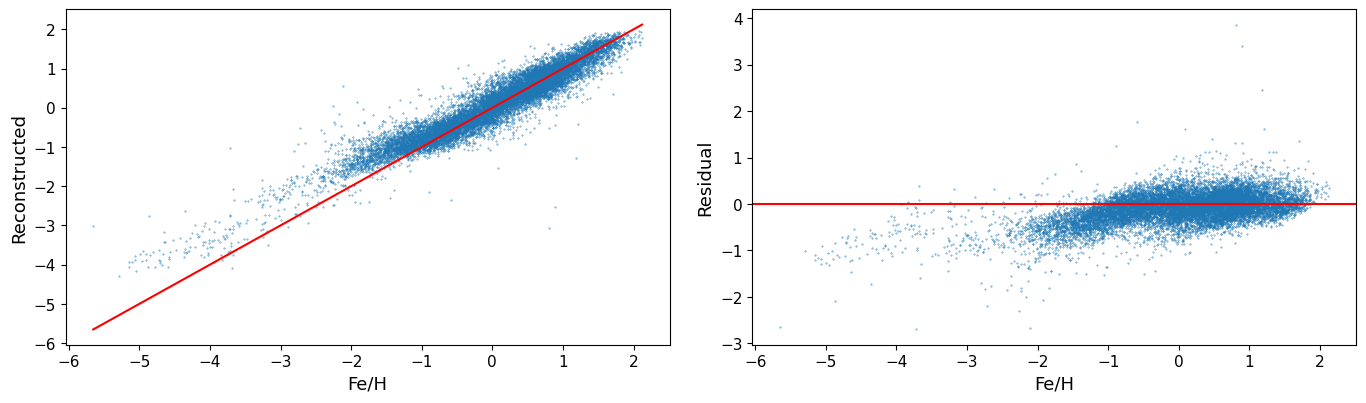

In [31]:
import matplotlib as mpl
plt.rc('font', size=18)

ind=0

fig = plt.figure(figsize = (14, 8))
# ax = fig.add_subplot(111)    # The big subplot
ax0 = fig.add_subplot(221)
ax1 = fig.add_subplot(222)
# ax2 = fig.add_subplot(223)
# ax3 = fig.add_subplot(224)
# plot the metallicity
ax0.scatter(standardized_abundance_test_arr[:,ind], test_reconstruction[:,ind], s=0.1)
ax0.plot(np.linspace(np.min(standardized_abundance_test_arr[:,ind]), np.max(standardized_abundance_test_arr[:,ind]), int(1e5)), np.linspace(np.min(standardized_abundance_test_arr[:,ind]), np.max(standardized_abundance_test_arr[:,ind]), int(1e5)), c='r')
ax0.set_xlabel('Fe/H'), ax0.set_ylabel('Reconstructed')
# plot the residuals of metallicity
# ax1.hist2d(standardized_abundance_test_arr[:,ind], standardized_abundance_test_arr[:,ind] - test_reconstruction[:,ind], norm=mpl.colors.LogNorm(), bins=200)
ax1.scatter(standardized_abundance_test_arr[:,ind], standardized_abundance_test_arr[:,ind] - test_reconstruction[:,ind], s=0.1)
ax1.set_xlabel(r'Fe/H'), ax1.set_ylabel('Residual')
# ax1.scatter(standardized_abundance_test_arr[:,ind], standardized_abundance_test_arr[:,ind] - test_reconstruction[:,ind], s=0.1)
ax1.axhline(0, c='r')
plt.tight_layout()
plt.savefig('metallicity_original_vs_reconstructed_naive.png')

In [32]:
np.std(standardized_abundance_test_arr[:,ind] - test_reconstruction[:,ind])

0.32152903

Plot:

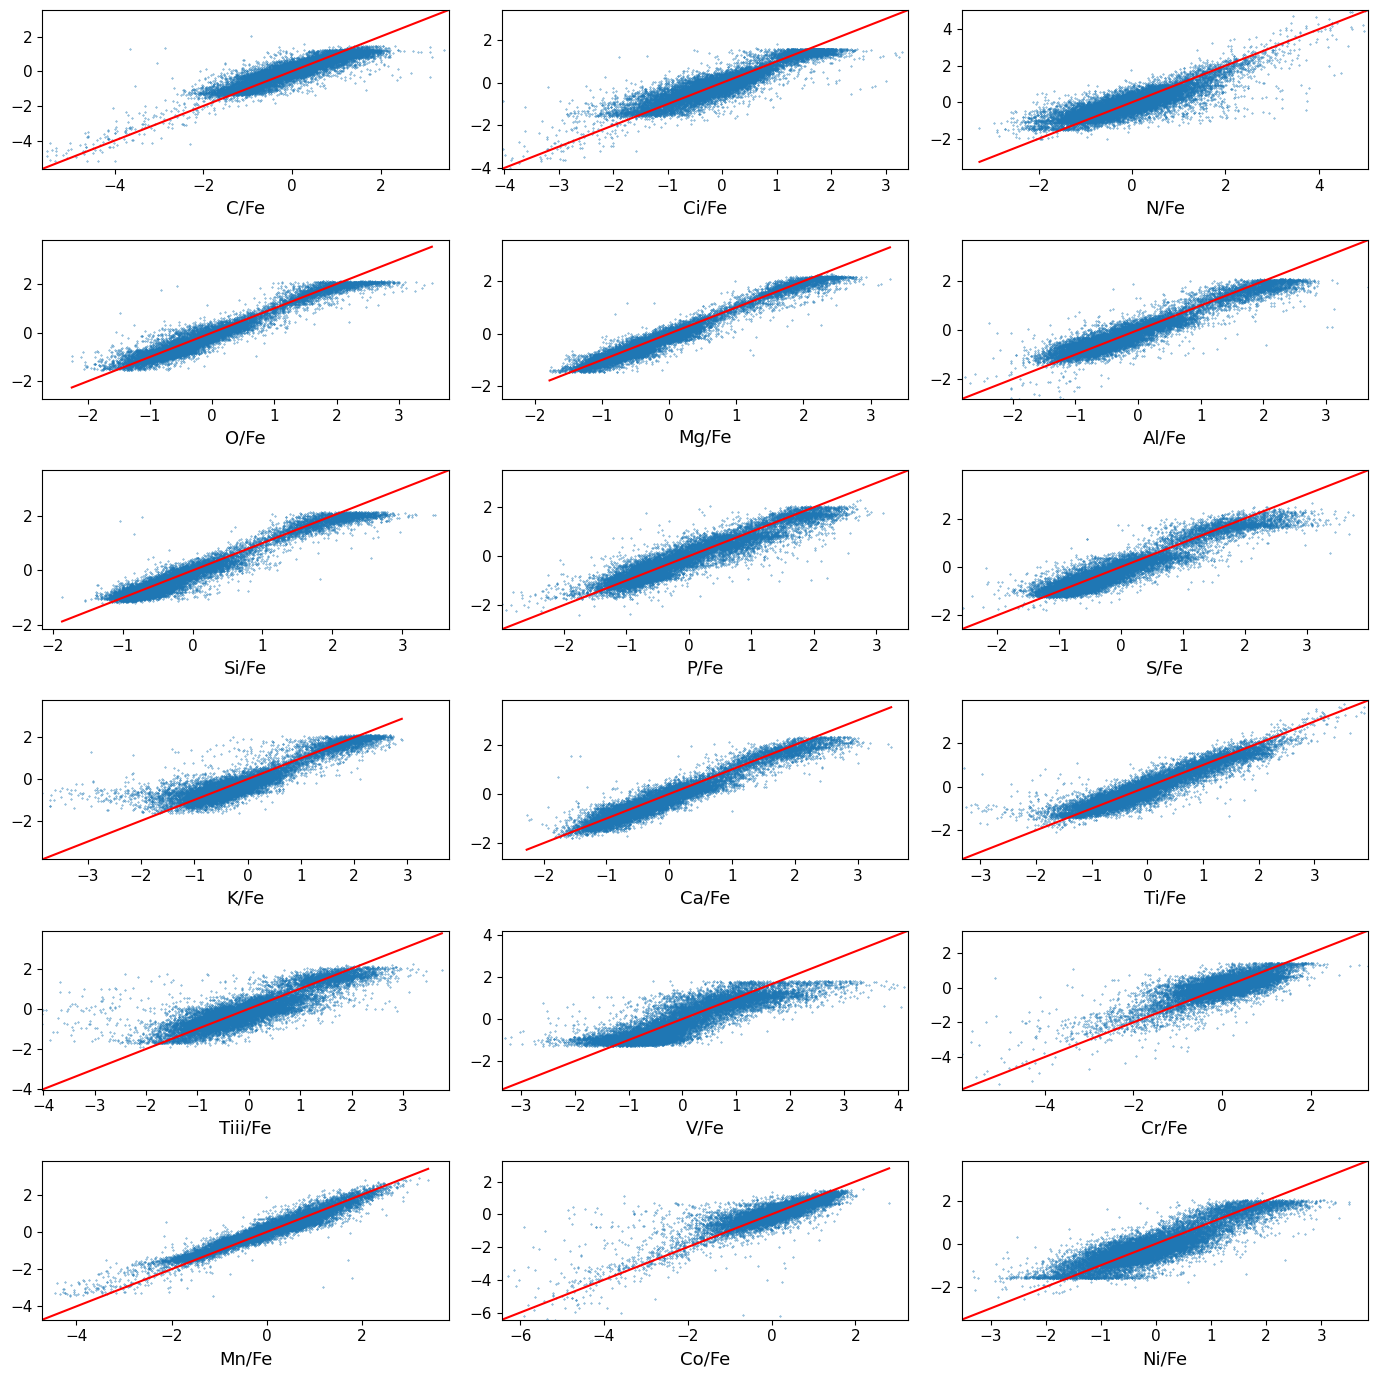

In [33]:
abundances = ['Fe/H', 'C/Fe', 'Ci/Fe', 'N/Fe', 'O/Fe', 'Mg/Fe', 'Al/Fe', 'Si/Fe', 'P/Fe', 'S/Fe', 'K/Fe', 'Ca/Fe', 'Ti/Fe', 'Tiii/Fe', 'V/Fe', 'Cr/Fe', 'Mn/Fe', 'Co/Fe', 'Ni/Fe']
divisor = 4  # fraction of the range to scale the plots by

plt.rc('font', size=14)
fig, ax = plt.subplots(6, 3, figsize=(14, 14))
for i in range(6):
    for j in range(3):
        ax[i, j].scatter(standardized_abundance_test_arr[:,3*i+j+1][::samp_rate], test_reconstruction[:,3*i+j+1][::samp_rate], s=0.1)
        # plt.plot(np.linspace(0., 0.3, int(1e4)), np.linspace(0., 0.3, int(1e4)), c='r')
        ax[i, j].plot(np.linspace(np.min(standardized_abundance_test_arr[:,3*i+j+1]), np.max(standardized_abundance_test_arr[:,3*i+j+1]), int(1e5)), 
                      np.linspace(np.min(standardized_abundance_test_arr[:,3*i+j+1]), np.max(standardized_abundance_test_arr[:,3*i+j+1]), int(1e5)), c='r')
        ax[i, j].set_xlabel(abundances[3*i+j+1])# , ax[i, j].set_ylabel('Reconstructed')       
        # scale it properly based on reconstruction
        abundance_min, abundance_max = np.quantile(standardized_abundance_test_arr[:,3*i+j+1], (0.005, 0.995))
        # abundance_min = np.min(test_reconstruction[:, 3*i + j])
        # abundance_max = np.max(test_reconstruction[:, 3*i + j])
        diff = np.abs(abundance_max - abundance_min)
        # scale it
        ax[i, j].set_xlim(abundance_min - diff/divisor, abundance_max + diff/divisor) 
        ax[i, j].set_ylim(abundance_min - diff/divisor, abundance_max + diff/divisor) 
        
plt.tight_layout()
plt.savefig('original_vs_reconstructed_naive_all.png')# , fmt='png')
plt.show()

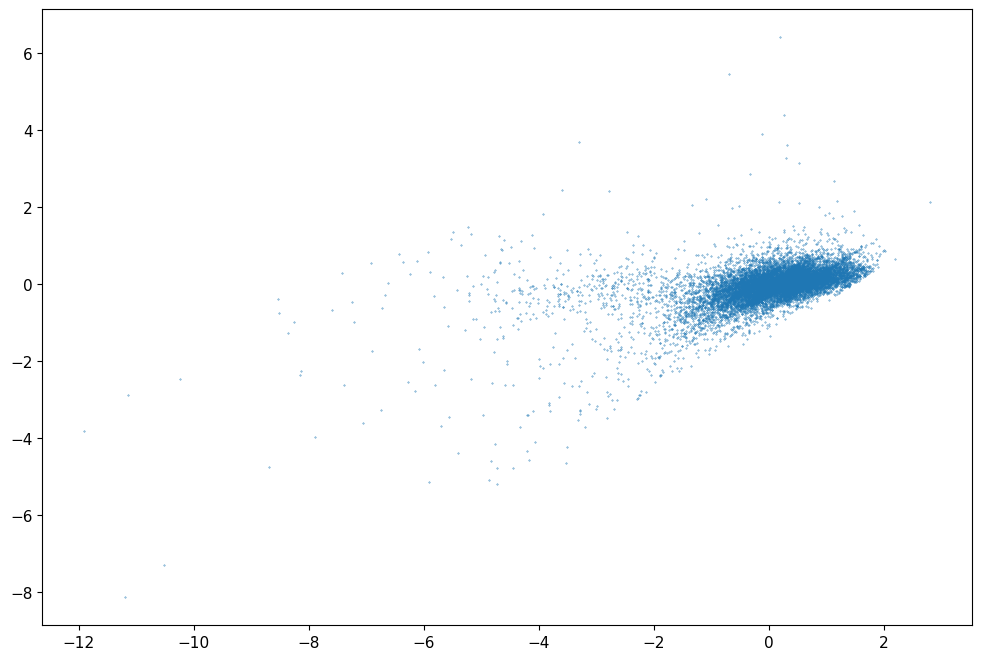

In [34]:
plt.scatter(standardized_abundance_test_arr[:,17], (standardized_abundance_test_arr[:,17] - test_reconstruction[:, 17]), s=0.1)